# Challenge Data Scientist - Javiera Morales

El problema que se busca solucionar en este desafío es predecir la probabilidad de atraso de los vuelos que aterrizan
o despegan del aeropuerto de Santiago de Chile.

Iniciamos el desafío importando los paquetes de python necesarios para la resolución de este.

In [195]:
# Para trabajo con el dataset
import pandas as pd
import numpy as np
from datetime import datetime
import statsmodels.api as sm

# Para visualización de los datos
import seaborn as sns
import matplotlib.pyplot as plt

# Para realizar modelos de machine learning para resolver el problema
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import xgboost as xgb
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.tree import DecisionTreeClassifier

sns.set_style("darkgrid")

Primero debemos cargar el dataset entregado que cuenta con información de vuelos que despegaron y aterrizaron en el
aeropuerto de Santiago.

In [35]:
dataset_scl = pd.read_csv('dataset_SCL.csv')

# Visualicemos las primeras 5 líneas del dataset (5 vuelos)
dataset_scl.head()

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (1,6) have mixed types. Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,1,1,2017,Domingo,I,American Airlines,Santiago,Miami
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,2,1,2017,Lunes,I,American Airlines,Santiago,Miami
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,3,1,2017,Martes,I,American Airlines,Santiago,Miami
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,4,1,2017,Miercoles,I,American Airlines,Santiago,Miami
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,5,1,2017,Jueves,I,American Airlines,Santiago,Miami


La primera pregunta que buscamos resolver es cómo se distribuyen los datos entregados, para lo que realizaremos
visualización gráfica de datos y posterior análisis cuantitativo para responder.

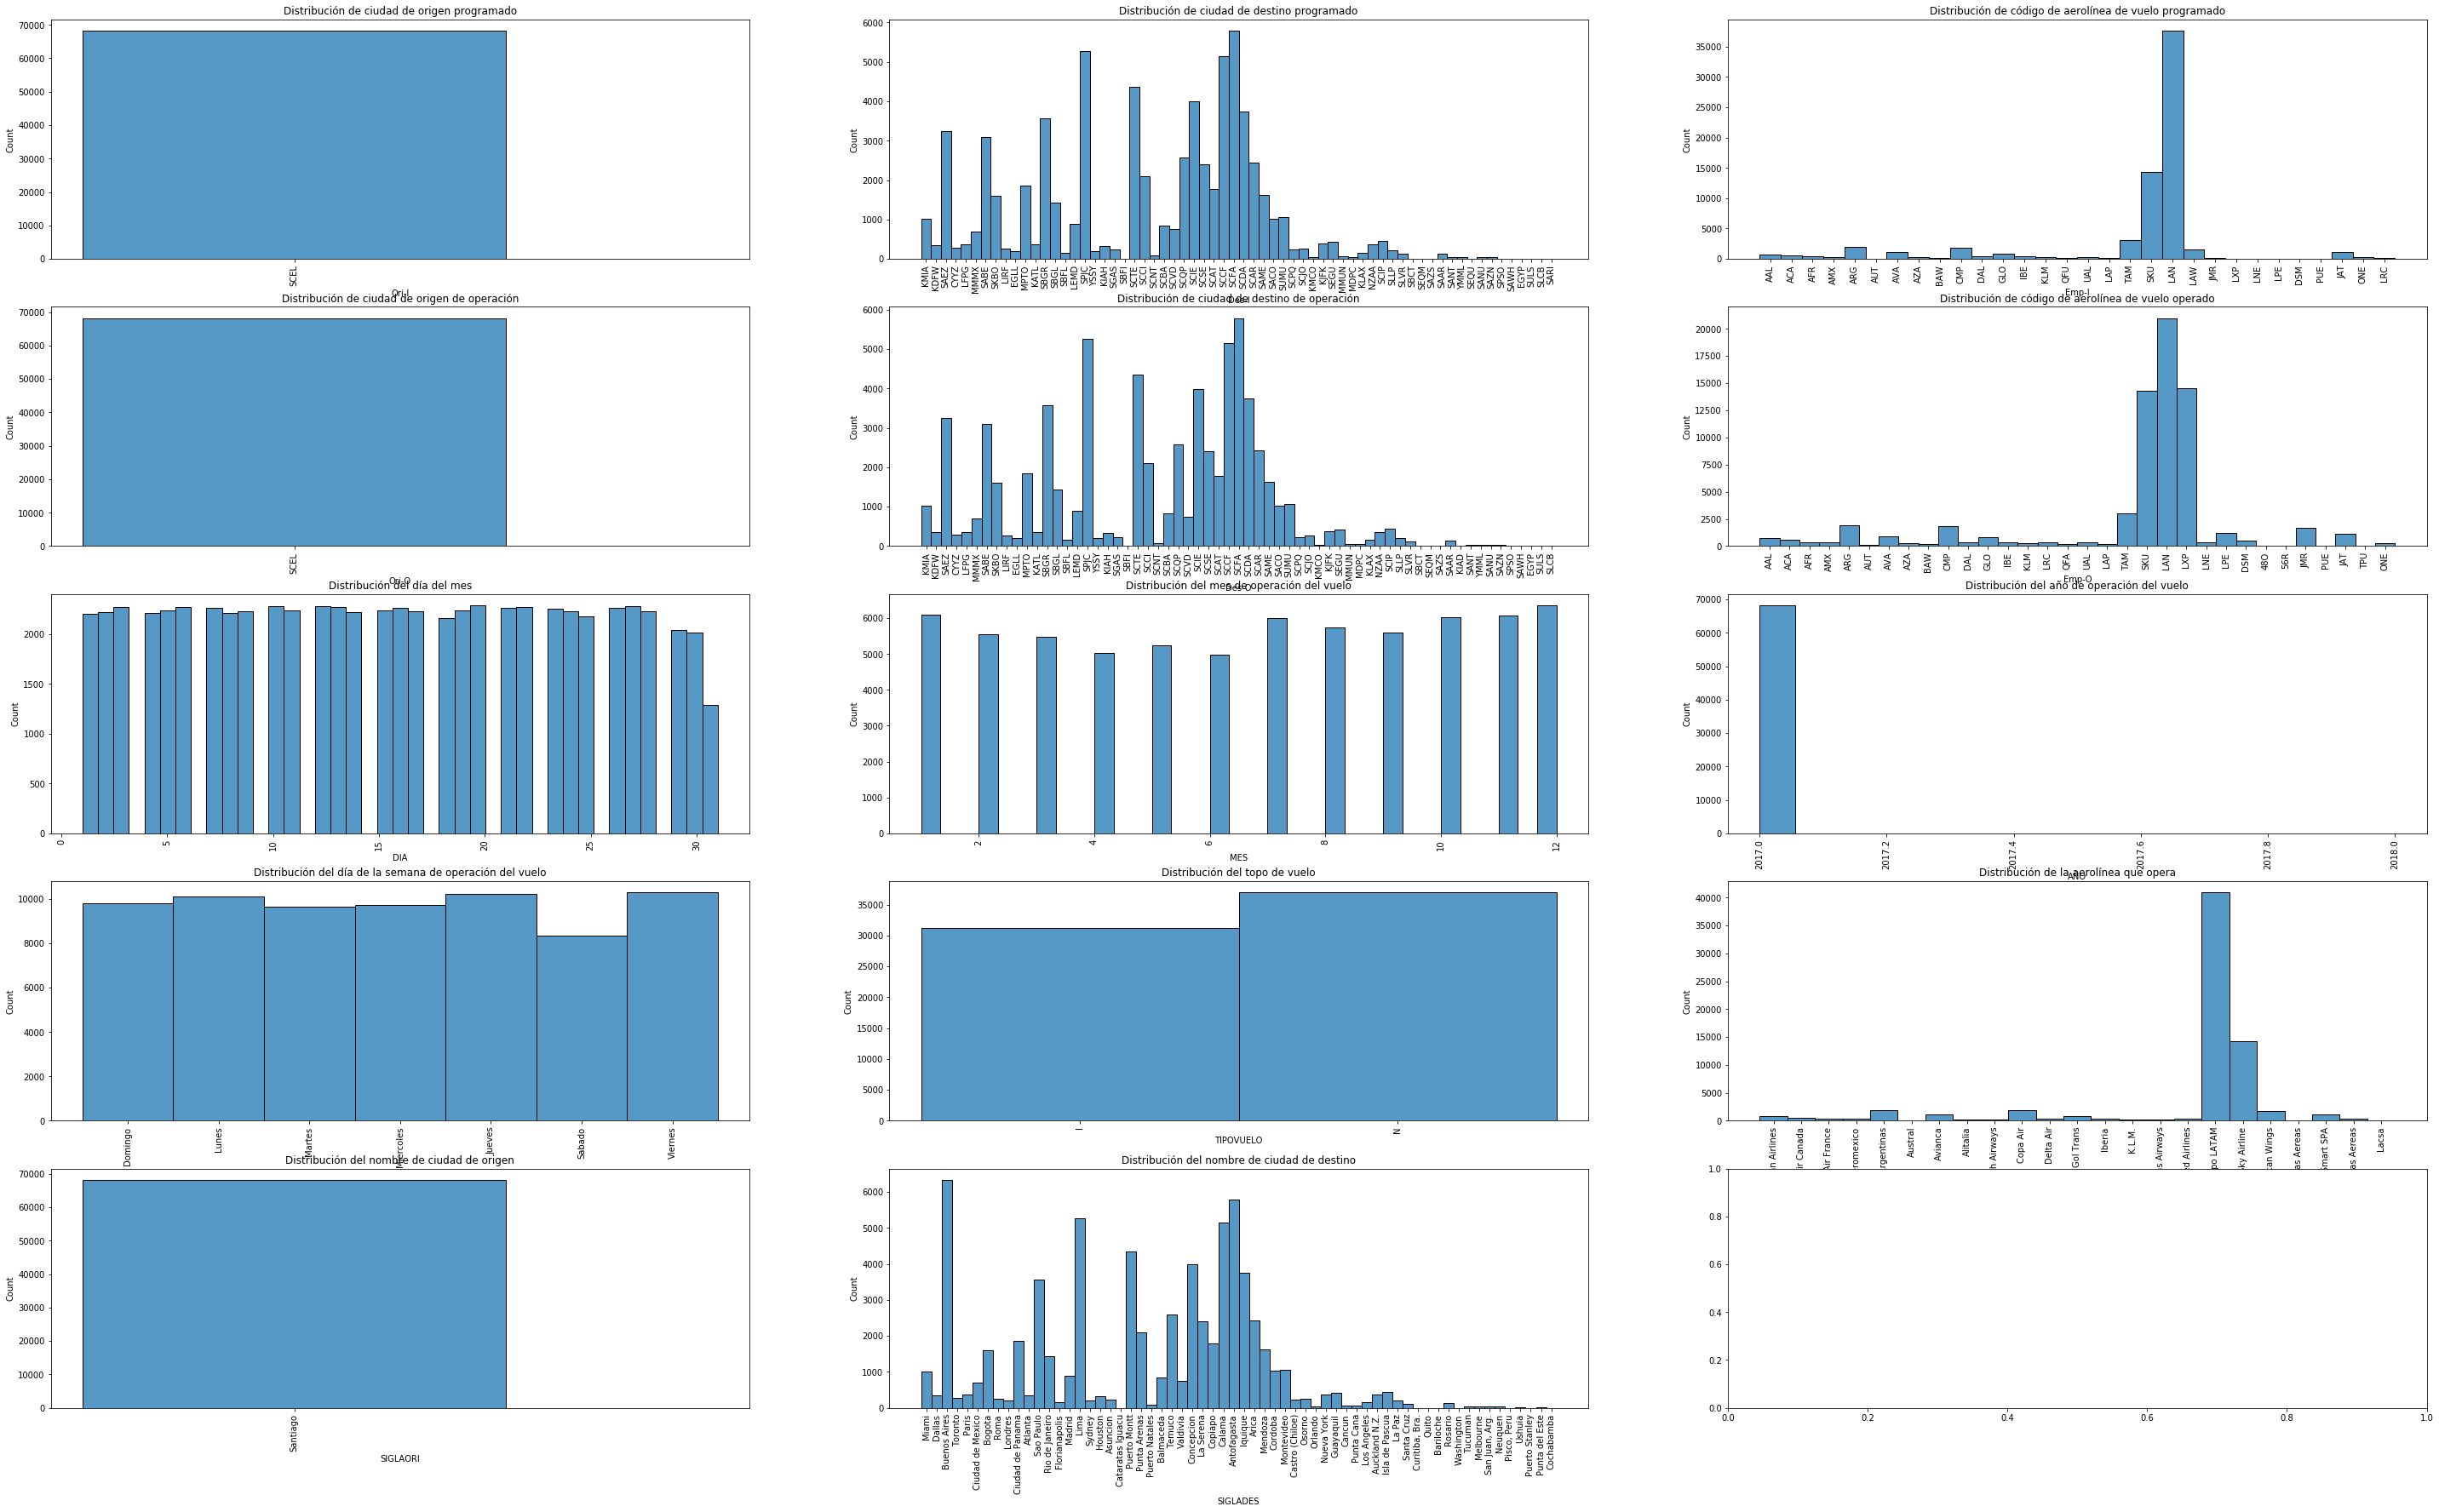

In [36]:
fig, ax = plt.subplots(5, 3, figsize = (50,30))
sns.histplot(dataset_scl['Ori-I'], ax = ax[0][0])
sns.histplot(dataset_scl['Des-I'], ax = ax[0][1])
sns.histplot(dataset_scl['Emp-I'], ax = ax[0][2])
sns.histplot(dataset_scl['Ori-O'], ax = ax[1][0])
sns.histplot(dataset_scl['Des-O'], ax = ax[1][1])
sns.histplot(dataset_scl['Emp-O'], ax = ax[1][2])
sns.histplot(dataset_scl['DIA'], ax = ax[2][0])
sns.histplot(dataset_scl['MES'], ax = ax[2][1])
sns.histplot(dataset_scl['AÑO'], ax = ax[2][2])
sns.histplot(dataset_scl['DIANOM'], ax = ax[3][0])
sns.histplot(dataset_scl['TIPOVUELO'], ax = ax[3][1])
sns.histplot(dataset_scl['OPERA'], ax = ax[3][2])
sns.histplot(dataset_scl['SIGLAORI'], ax = ax[4][0])
sns.histplot(dataset_scl['SIGLADES'], ax = ax[4][1])

ax[0][0].set_title('Distribución de ciudad de origen programado')
ax[0][1].set_title('Distribución de ciudad de destino programado')
ax[0][2].set_title('Distribución de código de aerolínea de vuelo programado')
ax[1][0].set_title('Distribución de ciudad de origen de operación')
ax[1][1].set_title('Distribución de ciudad de destino de operación')
ax[1][2].set_title('Distribución de código de aerolínea de vuelo operado')
ax[2][0].set_title('Distribución del día del mes')
ax[2][1].set_title('Distribución del mes de operación del vuelo')
ax[2][2].set_title('Distribución del año de operación del vuelo')
ax[3][0].set_title('Distribución del día de la semana de operación del vuelo')
ax[3][1].set_title('Distribución del topo de vuelo')
ax[3][2].set_title('Distribución de la aerolínea que opera')
ax[4][0].set_title('Distribución del nombre de ciudad de origen')
ax[4][1].set_title('Distribución del nombre de ciudad de destino')

ax[0][0].tick_params(axis='x', rotation=90)
ax[0][1].tick_params(axis='x', rotation=90)
ax[0][2].tick_params(axis='x', rotation=90)
ax[1][0].tick_params(axis='x', rotation=90)
ax[1][1].tick_params(axis='x', rotation=90)
ax[1][2].tick_params(axis='x', rotation=90)
ax[2][0].tick_params(axis='x', rotation=90)
ax[2][1].tick_params(axis='x', rotation=90)
ax[2][2].tick_params(axis='x', rotation=90)
ax[3][0].tick_params(axis='x', rotation=90)
ax[3][1].tick_params(axis='x', rotation=90)
ax[3][2].tick_params(axis='x', rotation=90)
ax[4][0].tick_params(axis='x', rotation=90)
ax[4][1].tick_params(axis='x', rotation=90)


In [5]:
#Distribución de vuelos (cantidad de vuelos por distintas variables) en números
print('Total de vuelos:', dataset_scl['Vlo-I'].count())
print('Total de destinos:', dataset_scl['SIGLADES'].nunique())
print('Distribución agruapada:')
dataset_scl[['Vlo-I','DIA']].groupby('DIA').count()
dataset_scl[['Vlo-I','MES']].groupby('MES').count()
dataset_scl[['Vlo-I','DIANOM']].groupby('DIANOM').count()
dataset_scl[['Vlo-I','TIPOVUELO']].groupby('TIPOVUELO').count()
dataset_scl[['Vlo-I','OPERA']].groupby('OPERA').count()
dataset_scl[['Vlo-I','SIGLADES']].groupby('SIGLADES').count().sort_values('Vlo-I',ascending=False)

Total de vuelos: 68206
Total de destinos: 62
Distribución agruapada:


,Vlo-I
SIGLADES,
Buenos Aires,6335
Antofagasta,5786
Lima,5270
Calama,5146
Puerto Montt,4357
...,...
Cataratas Iguacu,2
"Pisco, Peru",1
Puerto Stanley,1


De las distribuciones vistas de los datos podemos concluir que la ciudad de origen en todos los datos es Santiago de
Chile, tanto en lo programado como lo de operación. Además todos los datos que se tienen en la base de datos
corresponden a vuelos del año 2017.

Respecto a los meses, días y días de la semana de operación de los vuelos, no se ve gran diferencia entre los valores
de cada uno respectivamente, para los meses, se ve mayor cantidad de vuelos en los meses de Enero, Julio, Noviembre y
Diciembre, que corresponden a meses de temporada alta comúnmente en las vacaciones de verano e invierno de Chile,
los vuelos mensuales rondan entre los 5000 y 6000 vuelos; revisando la distribución por día del mes, siendo estos
alrededor de 2000 vuelos por día, se puede ver claramente una menor cantidad de vuelos en el último día 31 del mes,
pero también puede corresponder a que la mitad de los meses cuentan con el día 31, pero si se aprecia una baja de 200
vuelos aproximadamente en los últimos 3 días del mes; revisando los días de la semana, los días lunes, jueves y viernes
son los días con mayor cantidad de salidas de vuelos, superando los 10000 vuelos por día, mientras que los sábados son
los que menores salidas tienen, siendo estas una cantidad bajo 9000 vuelos.

Revisemos ahora la distribución de los datos por tipos de vuelo, salen más vuelos nacionales desde el aeropuerto de
Santiago que internacionales, pero no por una diferencia muy grande, esta diferencia es de 5726 vuelos. Las aerolíneas
con mayor operación corresponden a la del Grupo LATAM, seguido por Sky Airline, concentrando el 80% de los vuelos que
salen desde el aeropuerto de Santiago de Chile, Grupo LATAM solo se lleva cercano del 60% de los vuelos. Finalmente,
del total de 62 destinos que se encuentran en el dataset, los 5 destinos que más vuelos tuvieron durante el año 2017
son Buenos Aires, Antofagasta, Lima, Calama y Puerto Montt con más de 5000 vuelos al año y los destinos con menos
vuelos, Pisco, Puerto Stanley, Cochabamba y Washington con un solo vuelo en el año.

Generemos ahora las variables adicionales que nos ayudarán a generar un modelo predictivo de atraso de vuelo.

In [37]:
# Primero cambiemos las variables de Fecha-I y Fecha-O a variables tipo datetime, dado que son variables tipo str.
dataset_scl['Fecha-I'] = pd.to_datetime(dataset_scl['Fecha-I'])
dataset_scl['Fecha-O'] = pd.to_datetime(dataset_scl['Fecha-O'])


# Variable temporada alta
temporada_conditions = [
    ((dataset_scl['Fecha-I'].dt.date >= datetime.strptime('2017-07-15', '%Y-%m-%d').date())
     & (dataset_scl['Fecha-I'].dt.date <= datetime.strptime('2017-07-31', '%Y-%m-%d').date()))
|   ((dataset_scl['Fecha-I'].dt.date >= datetime.strptime('2017-09-11', '%Y-%m-%d').date())
     & (dataset_scl['Fecha-I'].dt.date <= datetime.strptime('2017-09-30', '%Y-%m-%d').date()))
|   ((dataset_scl['Fecha-I'].dt.date >= datetime.strptime('2017-01-01', '%Y-%m-%d').date())
     & (dataset_scl['Fecha-I'].dt.date <= datetime.strptime('2017-03-03', '%Y-%m-%d').date()))
|   ((dataset_scl['Fecha-I'].dt.date >= datetime.strptime('2017-12-15', '%Y-%m-%d').date()))

]
temporada_choices = [1]
dataset_scl['temporada_alta'] = np.select(temporada_conditions, temporada_choices, default=0)

# Diferencia en minutos
dataset_scl['dif_min'] = (dataset_scl['Fecha-O']- dataset_scl['Fecha-I']).dt.total_seconds()/60

# Booleano de si está atrasado o no el vuelo por 15 minutos
dataset_scl['atraso_15'] = np.where(dataset_scl['dif_min'] > 15, 1, 0)

# Periodo del día en que ocurre el vuelo (mañana, tarde, noche) en base a Fecha-I
period_conditions = [(dataset_scl['Fecha-I'].dt.time >= datetime.strptime('05:00:00', '%H:%M:%S').time())
                     & (dataset_scl['Fecha-I'].dt.time <= datetime.strptime('11:59:00', '%H:%M:%S').time()),
                     (dataset_scl['Fecha-I'].dt.time >= datetime.strptime('12:00:00', '%H:%M:%S').time())
                     & (dataset_scl['Fecha-I'].dt.time <= datetime.strptime('18:59:00', '%H:%M:%S').time())
                     ]
period_choices = ['mañana','tarde']
dataset_scl['periodo_dia'] = np.select(period_conditions, period_choices, default='noche')


Estas variables las guardaremos ahora en un archivo de csv separado con separador ";"

In [19]:
dataset_scl[['temporada_alta','dif_min','atraso_15','periodo_dia']].to_csv('synthetic_features.csv',sep = ';')
dataset_scl.to_csv('synthetic_features.csv',sep = ';')

Debemos revisar ahora el comportamiento de la tasa de atraso dependiendo de distintas variables, por destino,
aerolínea, mes del año, día de la semana, temporada y tipo de vuelo. Para revisar gráficamente el comportamiento de los
atrasos por las variables mencionadas se realizan boxplots, los que permiten identificar puntos atípicos (outliers) y
además identificar cómo se concentran los datos en los diferentes cuartiles, donde la barra del medio de la caja
corresponde a la media.

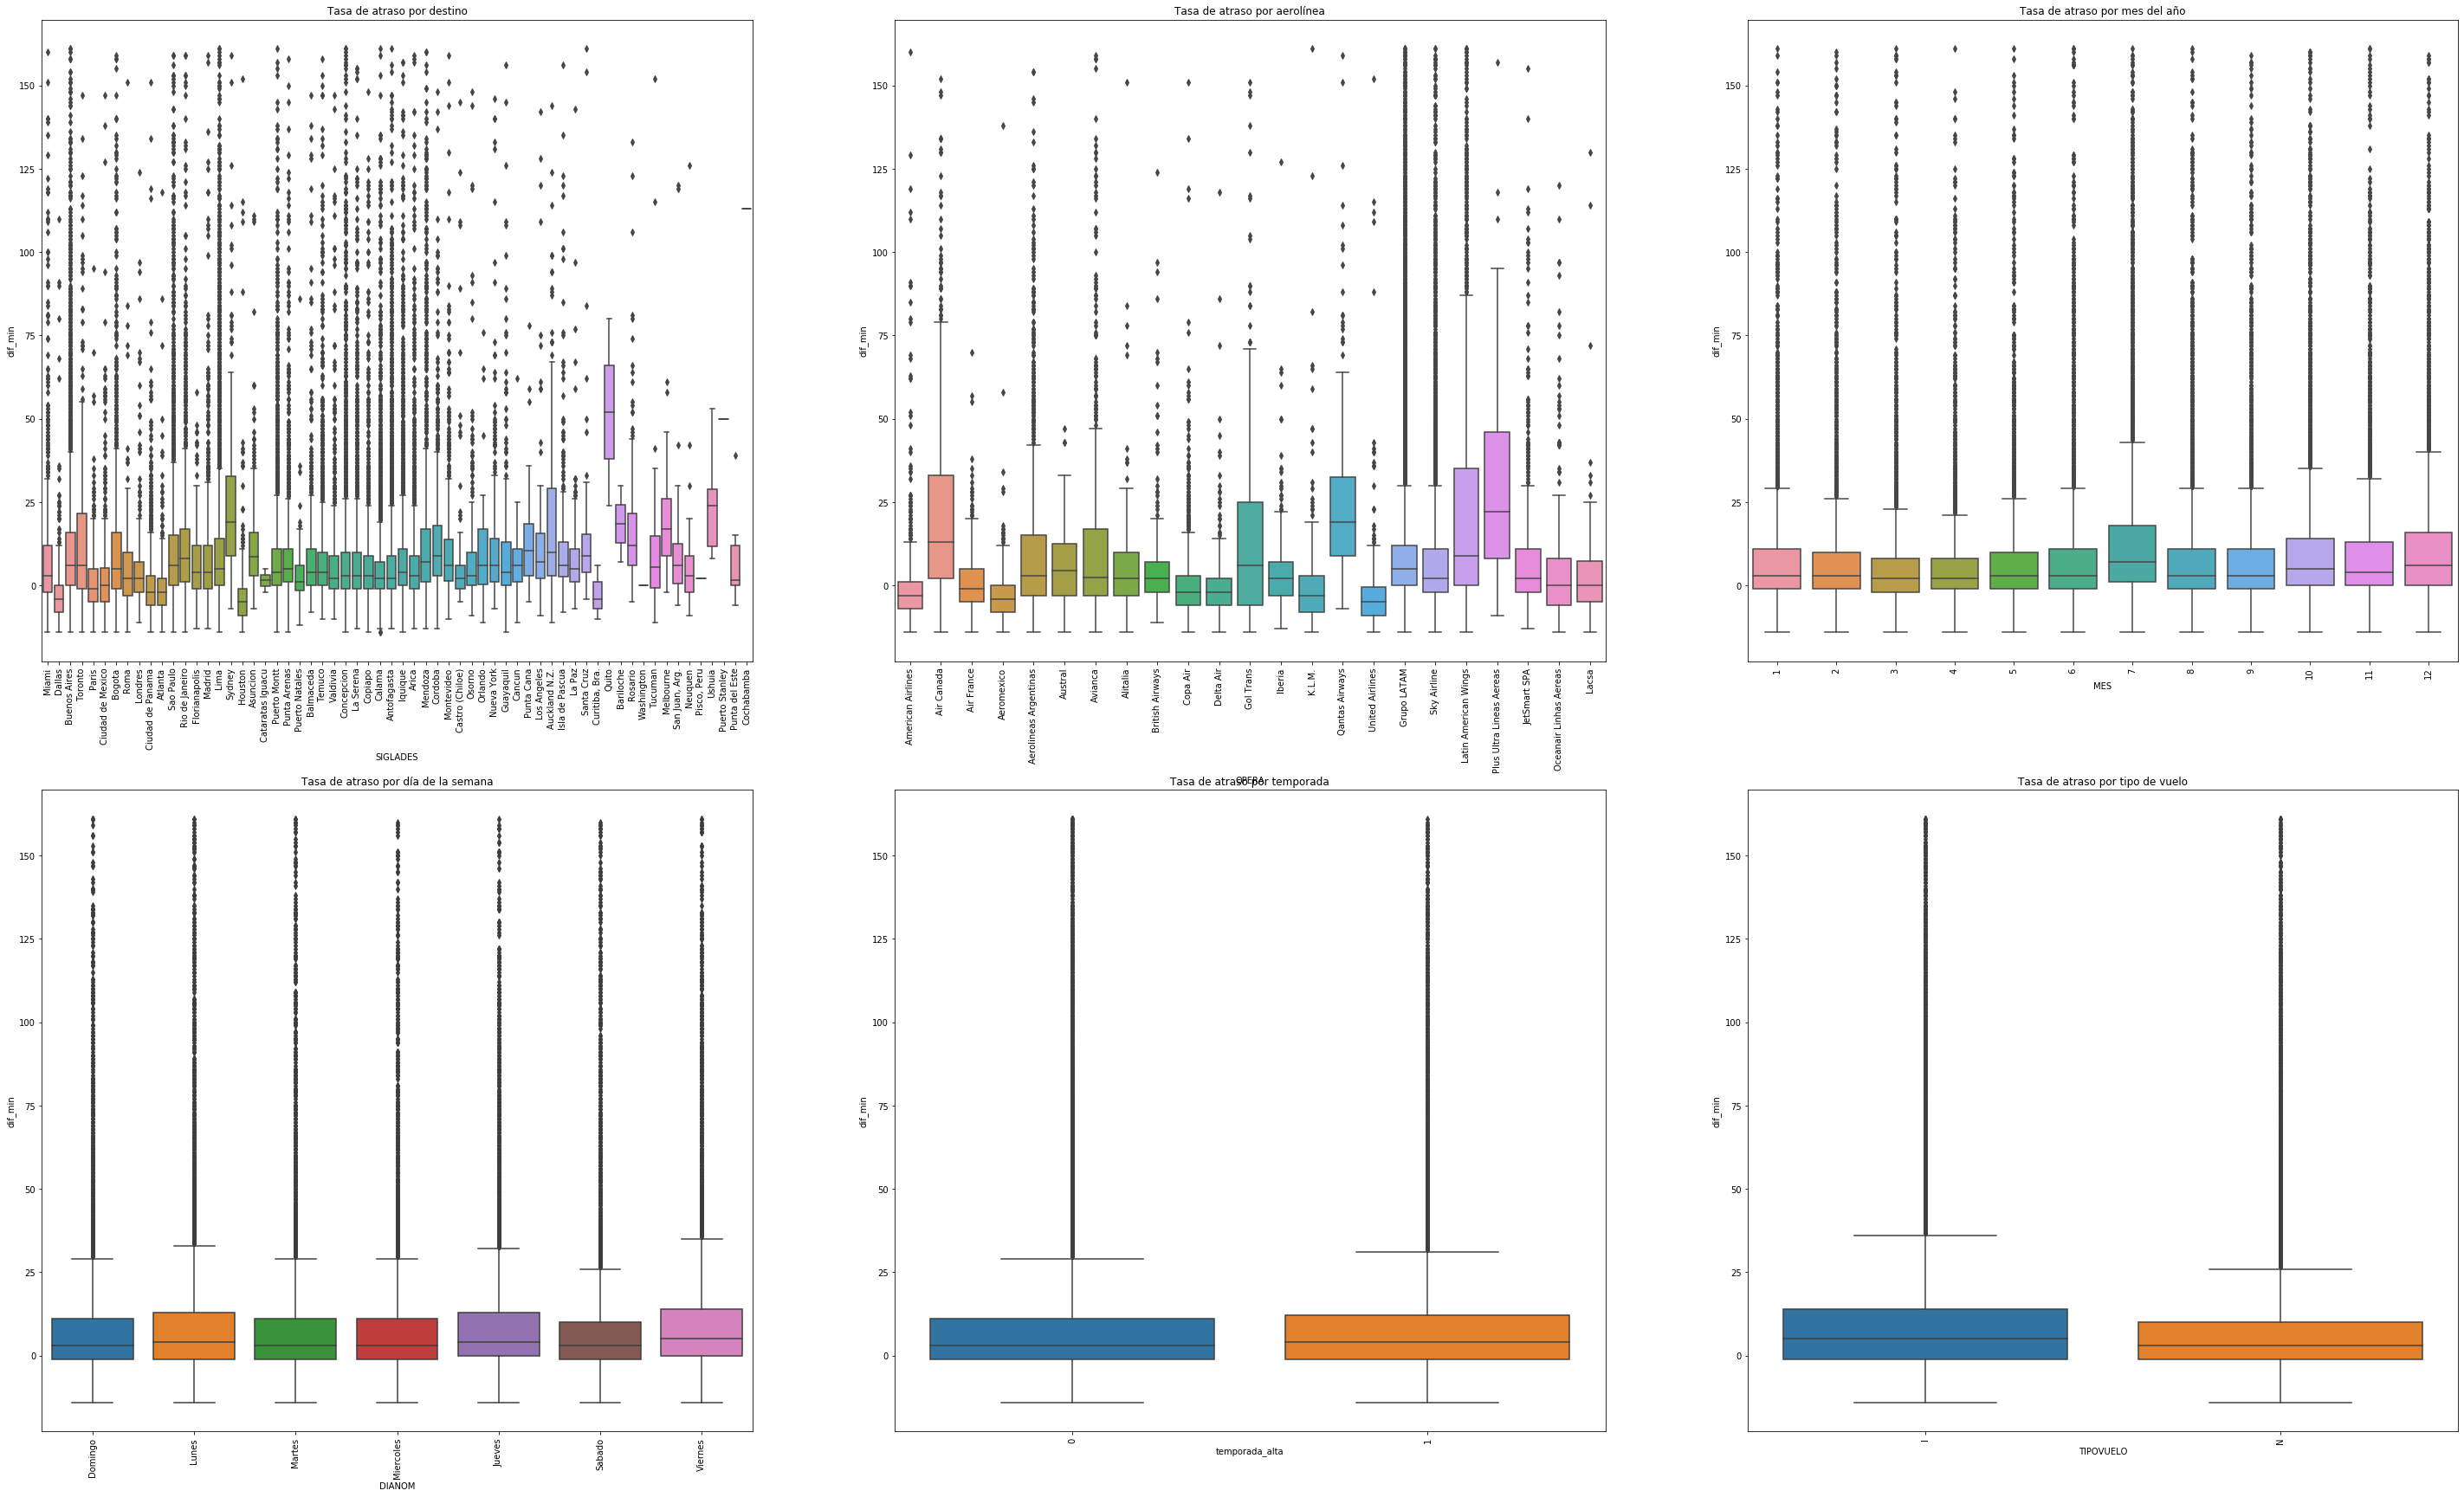

In [7]:
fig, ax = plt.subplots(2, 3, figsize = (50,30))

sns.boxplot(x='SIGLADES',y='dif_min',data=dataset_scl, ax = ax[0][0])
sns.boxplot(x='OPERA',y='dif_min',data=dataset_scl, ax = ax[0][1])
sns.boxplot(x='MES',y='dif_min',data=dataset_scl, ax = ax[0][2])
sns.boxplot(x='DIANOM',y='dif_min',data=dataset_scl, ax = ax[1][0])
sns.boxplot(x='temporada_alta',y='dif_min',data=dataset_scl, ax = ax[1][1])
sns.boxplot(x='TIPOVUELO',y='dif_min',data=dataset_scl, ax = ax[1][2])

ax[0][0].set_title('Diferencia en minutos por destino')
ax[0][1].set_title('Diferencia en minutos por aerolínea')
ax[0][2].set_title('Diferencia en minutos por mes del año')
ax[1][0].set_title('Diferencia en minutos por día de la semana')
ax[1][1].set_title('Diferencia en minutos por temporada')
ax[1][2].set_title('Diferencia en minutos por tipo de vuelo')

ax[0][0].tick_params(axis='x', rotation=90)
ax[0][1].tick_params(axis='x', rotation=90)
ax[0][2].tick_params(axis='x', rotation=90)
ax[1][0].tick_params(axis='x', rotation=90)
ax[1][1].tick_params(axis='x', rotation=90)
ax[1][2].tick_params(axis='x', rotation=90)

In [8]:
dataset_scl[['SIGLADES','OPERA','MES','DIANOM','temporada_alta','TIPOVUELO','dif_min']].groupby(
    ['SIGLADES','OPERA','MES','DIANOM','temporada_alta','TIPOVUELO']).min()
dataset_scl[['SIGLADES','OPERA','MES','DIANOM','temporada_alta','TIPOVUELO','dif_min']].groupby(
    ['SIGLADES','OPERA','MES','DIANOM','temporada_alta','TIPOVUELO']).mean()
dataset_scl[['SIGLADES','OPERA','MES','DIANOM','temporada_alta','TIPOVUELO','dif_min']].groupby(
    ['SIGLADES','OPERA','MES','DIANOM','temporada_alta','TIPOVUELO']).max()

dif_min
SIGLADES    OPERA           MES DIANOM    temporada_alta TIPOVUELO         
Antofagasta Grupo LATAM     1   Domingo   1              N             29.0
                                Jueves    1              N            119.0
                                Lunes     1              N             22.0
                                Martes    1              N             35.0
                                Miercoles 1              N             98.0
...                                                                     ...
Valdivia    Sky Airline     12  Miercoles 1              N             50.0
                                Sabado    1              N             29.0
                                Viernes   0              N             52.0
                                          1              N            143.0
Washington  United Airlines 8   Martes    0              I              0.0

[7780 rows x 1 columns]

In [9]:
dataset_scl['atraso_15'].value_counts()
print('Tasa de atraso general:',round(len(dataset_scl[dataset_scl['atraso_15']==1])/len(dataset_scl),3))

Tasa de atraso general: 0.185


Ahora crearemos la variable tasa de atraso en un dataset acotado a las variables que se buscan que puedan explicar el
atraso en los vuelos.

In [70]:
sum_dataset = dataset_scl[['OPERA','SIGLADES','DIANOM','TIPOVUELO','temporada_alta','MES','atraso_15']].groupby(
    ['OPERA','SIGLADES','DIANOM','TIPOVUELO','temporada_alta','MES']).sum()
count_dataset = dataset_scl[['OPERA','SIGLADES','DIANOM','TIPOVUELO','temporada_alta','MES','atraso_15']].groupby(
    ['OPERA','SIGLADES','DIANOM','TIPOVUELO','temporada_alta','MES']).count()

late_rate = pd.merge(sum_dataset,count_dataset, left_index=True, right_index=True)
late_rate['tasa_atraso'] = late_rate.atraso_15_x/late_rate.atraso_15_y
late_rate.reset_index(drop=False,inplace=True)
late_rate.head()

,OPERA,SIGLADES,DIANOM,TIPOVUELO,temporada_alta,MES,atraso_15_x,atraso_15_y,tasa_atraso
0,Aerolineas Argentinas,Buenos Aires,Domingo,I,0,3,1,19,0.052632
1,Aerolineas Argentinas,Buenos Aires,Domingo,I,0,4,3,29,0.103448
2,Aerolineas Argentinas,Buenos Aires,Domingo,I,0,5,5,24,0.208333
3,Aerolineas Argentinas,Buenos Aires,Domingo,I,0,6,5,24,0.208333
4,Aerolineas Argentinas,Buenos Aires,Domingo,I,0,7,2,12,0.166667


Para explicar qué variables afectan más a la tasa de atraso utilizaremos una regresión lineal explicativa.

In [71]:
# Creamos variables dummies para las categóricas para que puedan ser consideradas en la regresión
late_rate = pd.concat((late_rate,
                       pd.get_dummies(late_rate['OPERA'],drop_first=True),
                       pd.get_dummies(late_rate['SIGLADES'],drop_first=True),
                       pd.get_dummies(late_rate['DIANOM'],drop_first=True),
                       pd.get_dummies(late_rate['TIPOVUELO'],drop_first=True)), axis=1)
late_rate.head()

,OPERA,SIGLADES,DIANOM,TIPOVUELO,temporada_alta,MES,atraso_15_x,atraso_15_y,tasa_atraso,Aeromexico,...,Ushuia,Valdivia,Washington,Jueves,Lunes,Martes,Miercoles,Sabado,Viernes,N
0,Aerolineas Argentinas,Buenos Aires,Domingo,I,0,3,1,19,0.052632,0,...,0,0,0,0,0,0,0,0,0,0
1,Aerolineas Argentinas,Buenos Aires,Domingo,I,0,4,3,29,0.103448,0,...,0,0,0,0,0,0,0,0,0,0
2,Aerolineas Argentinas,Buenos Aires,Domingo,I,0,5,5,24,0.208333,0,...,0,0,0,0,0,0,0,0,0,0
3,Aerolineas Argentinas,Buenos Aires,Domingo,I,0,6,5,24,0.208333,0,...,0,0,0,0,0,0,0,0,0,0
4,Aerolineas Argentinas,Buenos Aires,Domingo,I,0,7,2,12,0.166667,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7775,United Airlines,Houston,Viernes,I,1,3,0,1,0.000000,0,...,0,0,0,0,0,0,0,0,1,0
7776,United Airlines,Houston,Viernes,I,1,7,0,2,0.000000,0,...,0,0,0,0,0,0,0,0,1,0
7777,United Airlines,Houston,Viernes,I,1,9,0,3,0.000000,0,...,0,0,0,0,0,0,0,0,1,0
7778,United Airlines,Houston,Viernes,I,1,12,1,4,0.250000,0,...,0,0,0,0,0,0,0,0,1,0


In [81]:
y = late_rate['tasa_atraso']
X = late_rate.drop(['tasa_atraso','OPERA','SIGLADES','DIANOM','TIPOVUELO','atraso_15_x','atraso_15_y'],axis=1)
lm = sm.OLS(y, X)
res = lm.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:            tasa_atraso   R-squared:                       0.245
Model:                            OLS   Adj. R-squared:                  0.237
Method:                 Least Squares   F-statistic:                     29.05
Date:                Mon, 07 Nov 2022   Prob (F-statistic):               0.00
Time:                        20:59:58   Log-Likelihood:                 1048.6
No. Observations:                7780   AIC:                            -1923.
Df Residuals:                    7693   BIC:                            -1318.
Df Model:                          86                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
temporada_alta          

Visualicemos gráficamente la tasa de atraso.

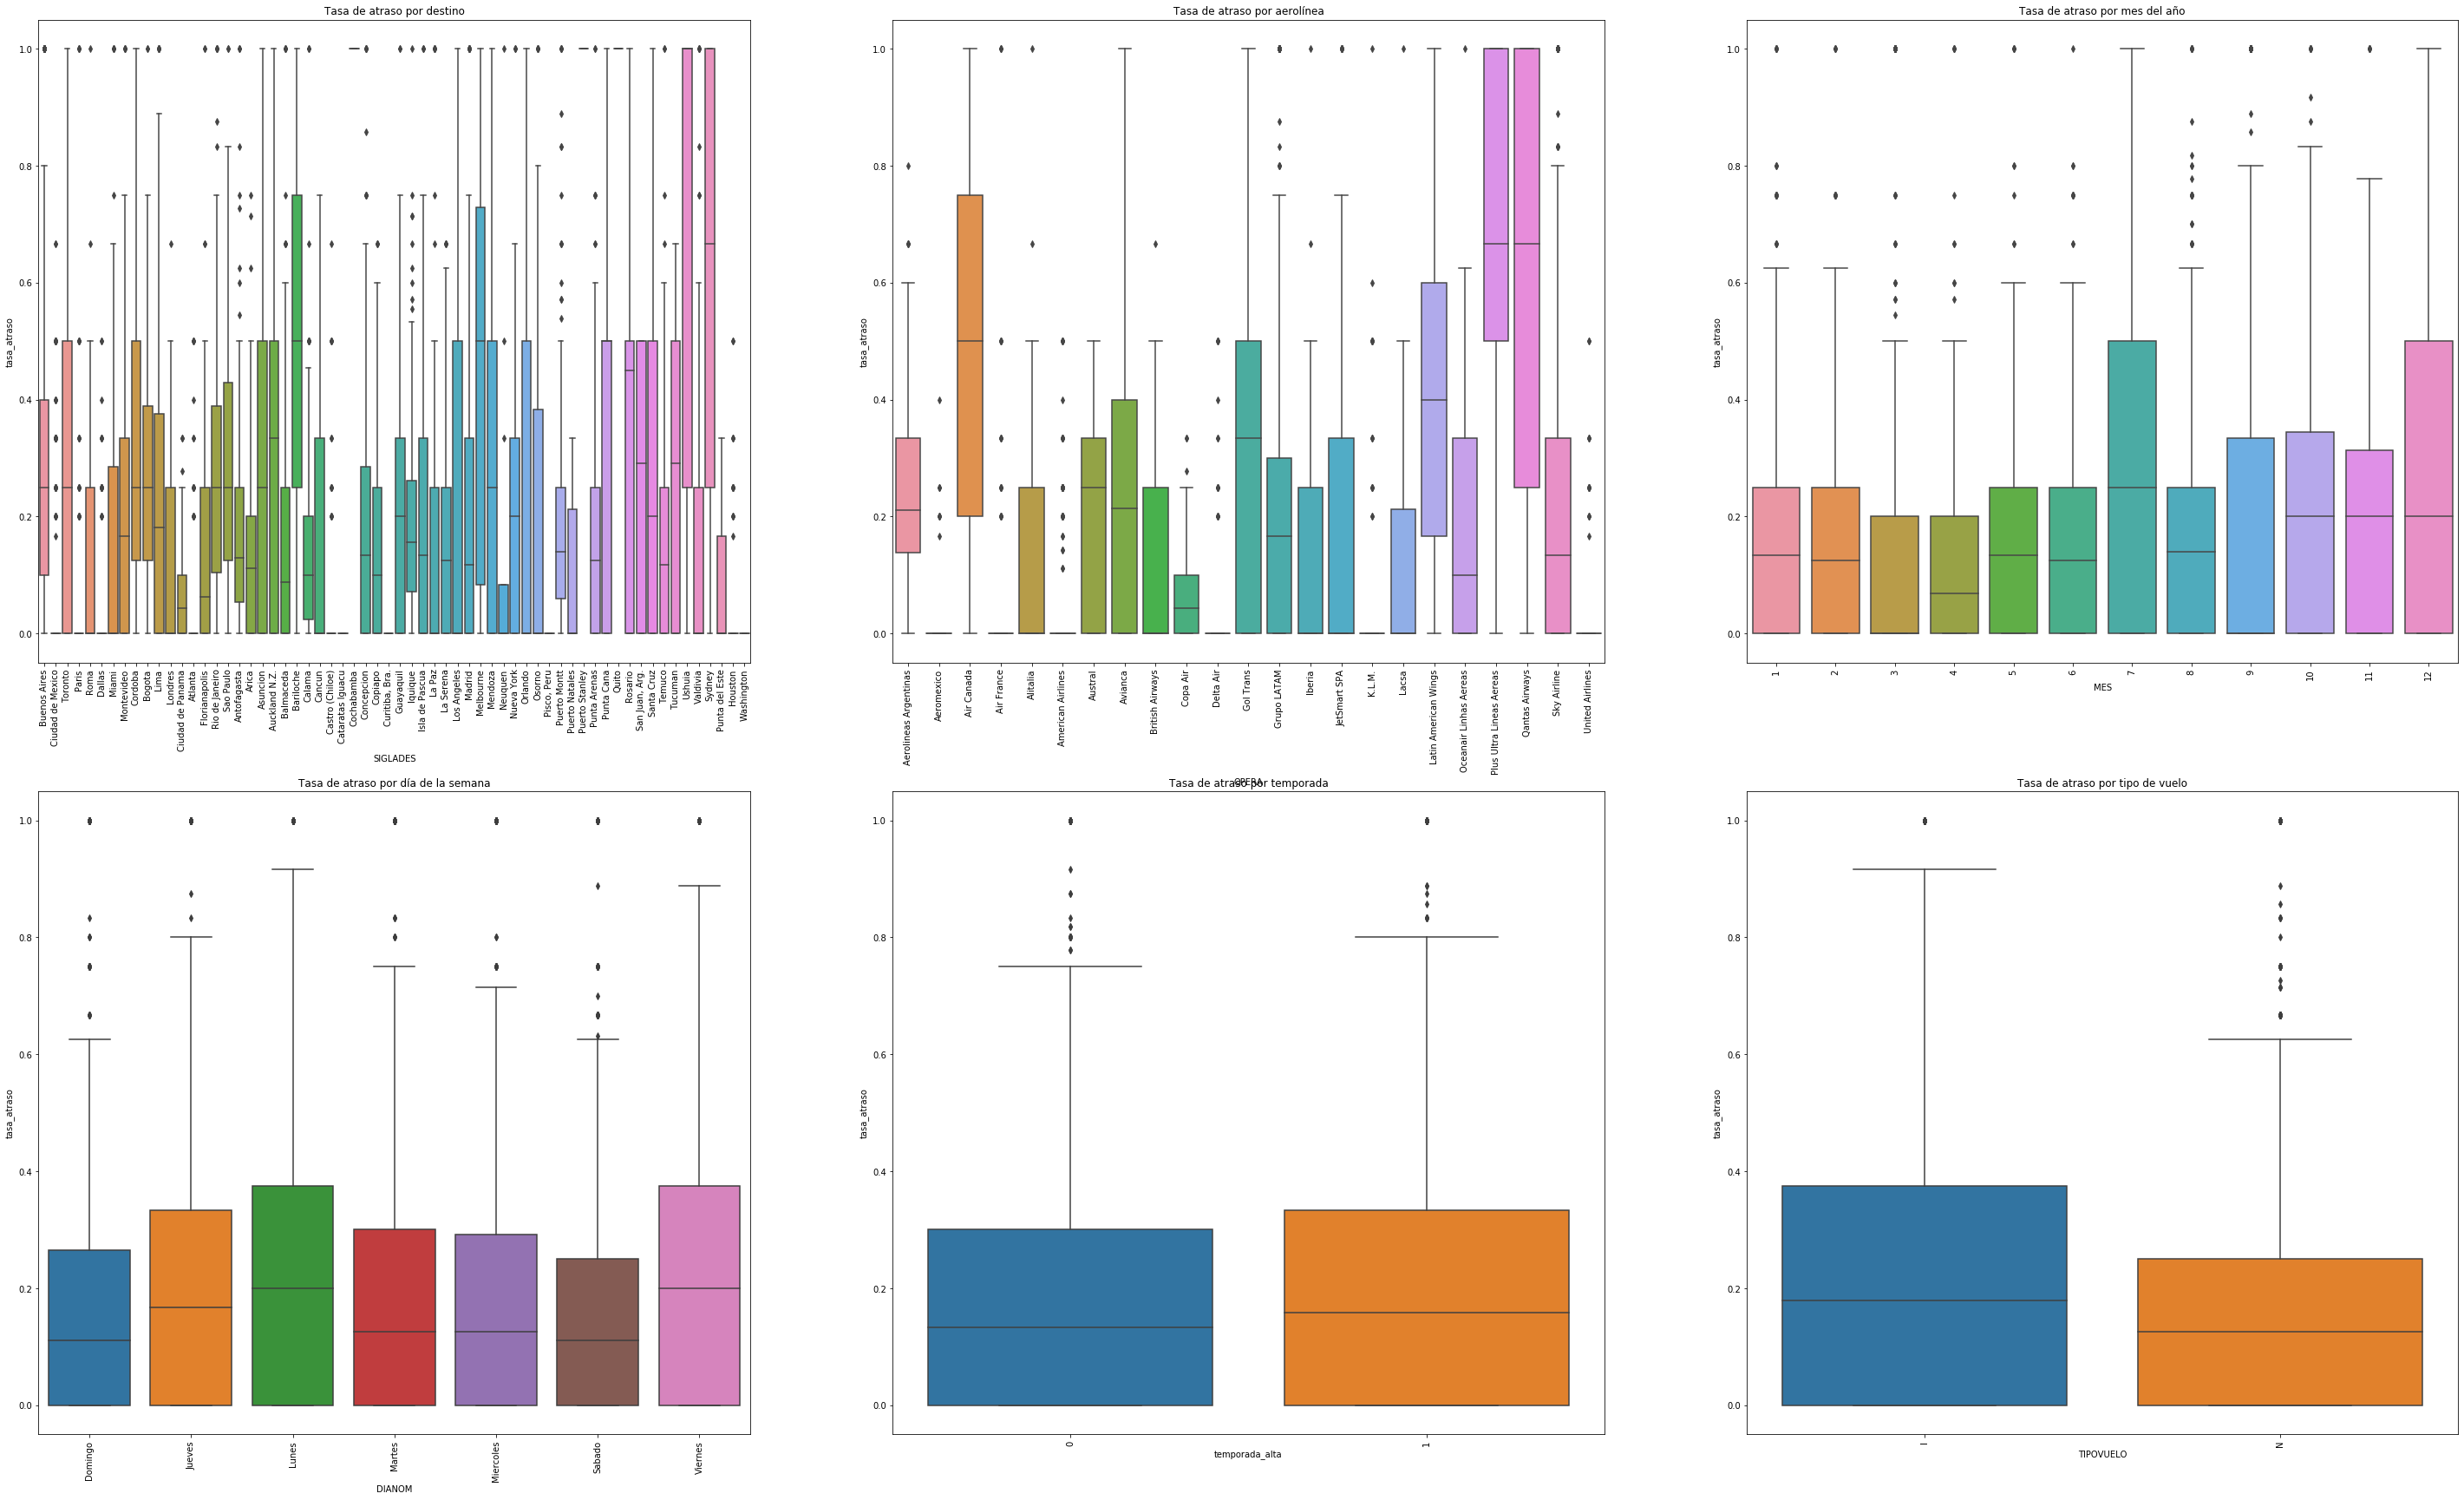

In [83]:
fig, ax = plt.subplots(2, 3, figsize = (50,30))

sns.boxplot(x='SIGLADES',y='tasa_atraso',data=late_rate, ax = ax[0][0])
sns.boxplot(x='OPERA',y='tasa_atraso',data=late_rate, ax = ax[0][1])
sns.boxplot(x='MES',y='tasa_atraso',data=late_rate, ax = ax[0][2])
sns.boxplot(x='DIANOM',y='tasa_atraso',data=late_rate, ax = ax[1][0])
sns.boxplot(x='temporada_alta',y='tasa_atraso',data=late_rate, ax = ax[1][1])
sns.boxplot(x='TIPOVUELO',y='tasa_atraso',data=late_rate, ax = ax[1][2])

ax[0][0].set_title('Tasa de atraso por destino')
ax[0][1].set_title('Tasa de atraso por aerolínea')
ax[0][2].set_title('Tasa de atraso por mes del año')
ax[1][0].set_title('Tasa de atraso por día de la semana')
ax[1][1].set_title('Tasa de atraso por temporada')
ax[1][2].set_title('Tasa de atraso por tipo de vuelo')

ax[0][0].tick_params(axis='x', rotation=90)
ax[0][1].tick_params(axis='x', rotation=90)
ax[0][2].tick_params(axis='x', rotation=90)
ax[1][0].tick_params(axis='x', rotation=90)
ax[1][1].tick_params(axis='x', rotation=90)
ax[1][2].tick_params(axis='x', rotation=90)

Del comportamiento estudiado anteriormente podemos concluir que viendo el p-value (si el p-value es menor a 0.05 se
considera estadísticamente significativa la variable), las variables que más influirían en la predicción de atrasos
serían la temporada, el mes de operación del vuelo, el día de la semana, si es lunes, jueves o viernes, algunas
aerolíneas, pero las que tienen mayor cantidad de datos como LATAM y Sky no son significativas para predicir los
atrasos, algunos destinos también. Y lo que es relevante y sobresale a la vista es que el tipo de vuelo no sería
relevante en la predicción de atraso de vuelo, es decir, los atrasos son independientes de si el vuelo es nacional
o internacional.

Continuamos ahora el desafío con la parte de entrenamiento del modelo. Para entrenar este modelo debemos considerar las
variables creadas anteriormente junto con las entregadas en el dataset original.

Este modelo corresponde a un modelo de clasificación, dado que consideraremos como atraso si la diferencia en minutos
entre Fecha-I y Fecha-O es de 15 minutos, tal como se creó la variable atraso_15. Por lo que utilizaremos dicha variable
como target para nuestro entrenamiento y posterior validación.

In [102]:
model_data = pd.concat((dataset_scl,
                        pd.get_dummies(dataset_scl['OPERA'],drop_first=True),
                        pd.get_dummies(dataset_scl['SIGLADES'],drop_first=True),
                        pd.get_dummies(dataset_scl['DIANOM'],drop_first=True),
                        pd.get_dummies(dataset_scl['periodo_dia'],drop_first=True)), axis=1)

In [106]:
X = model_data.loc[:, model_data.columns != 'atraso_15']
y = model_data.loc[:, model_data.columns == 'atraso_15']

# Eliminamos las variables que no utilizaremos en el modelo que ya son explicadas por otras variables
X.drop(['Fecha-I', 'Vlo-I', 'Ori-I', 'Des-I', 'Emp-I', 'Fecha-O', 'Vlo-O',
       'Ori-O', 'Des-O', 'Emp-O','SIGLAORI','dif_min','AÑO','TIPOVUELO',
        'OPERA','SIGLADES','DIANOM','periodo_dia'],axis = 1, inplace = True)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/frame.py:4110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [107]:
# Separamos en data de entrenamiento y de testeo
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [116]:
pb_model = sm.Probit(y_train, X_train)
res_pb = pb_model.fit(method='bfgs')
print(res_pb.summary2())

         Current function value: 0.462790
         Iterations: 35
         Function evaluations: 39
         Gradient evaluations: 39
                         Results: Probit
Model:              Probit           Pseudo R-squared: 0.033      
Dependent Variable: atraso_15        AIC:              50677.3544 
Date:               2022-11-07 21:51 BIC:              51452.2747 
No. Observations:   54564            Log-Likelihood:   -25252.    
Df Model:           86               LL-Null:          -26125.    
Df Residuals:       54477            LLR p-value:      1.0354e-307
Converged:          0.0000           Scale:            1.0000     
------------------------------------------------------------------
                           Coef.  Std.Err.  z  P>|z| [0.025 0.975]
------------------------------------------------------------------
DIA                       -0.0084      nan nan   nan    nan    nan
MES                        0.0182      nan nan   nan    nan    nan
temporada_alta       

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


El modelo no convergió, por lo que probaremos con otros tipos de modelos que no sean regresiones.

Probaremos modelos de árboles de clasificación. Primero un Random Forest y seguiremos con un XGBoost.

Antes de entrenar el modelo final debemos probar con distintas cantidades de estimadores y medir el
accuracy (métrica estrella de los modelos de clasificación) para elegir el número de estimadores que
maximicen el accuracy esperado.

<ipython-input-163-1bb115c434e4>:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_class.fit(X_train, y_train)
<ipython-input-163-1bb115c434e4>:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_class.fit(X_train, y_train)
<ipython-input-163-1bb115c434e4>:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_class.fit(X_train, y_train)
<ipython-input-163-1bb115c434e4>:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_class.fit(X_train, y_train)
<ipython-input-163-1bb115c434e4>:6: DataConversionWarning: A column-vector y was passed when a 1d array 

Text(0, 0.5, 'Testing Accuracy')

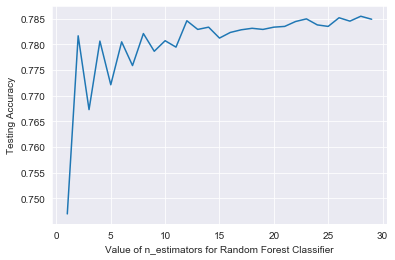

In [163]:
scores =[]
for n in range(1, 30):
    rf_class = RandomForestClassifier(n_estimators=n,
                                 max_features='auto',
                                 random_state=0)
    rf_class.fit(X_train, y_train)
    y_pred = rf_class.predict(X_test)
    scores.append(accuracy_score(y_test, y_pred))

plt.plot(range(1, 30), scores)
plt.xlabel('Value of n_estimators for Random Forest Classifier')
plt.ylabel('Testing Accuracy')

In [164]:
# Utilizamos la librería de Random Forest de scikit-learn Random Forest Classifier
# En base al gráfico de accuracy anterior el número de estimadores elegido es de 12.
rf_model = RandomForestClassifier(n_estimators=12,
                                  max_features='auto',
                                  random_state=0)
rf_model.fit(X_train,y_train)

<ipython-input-164-0e3ddeb843ab>:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train,y_train)


RandomForestClassifier(n_estimators=12, random_state=0)

In [174]:
y_pred = rf_model.predict(X_test)
rf_probability = rf_model.predict_proba(X_test)

rf_probability [[0.75       0.25      ]
 [0.86666667 0.13333333]
 [0.375      0.625     ]
 ...
 [1.         0.        ]
 [1.         0.        ]
 [0.         1.        ]]


Veamos un par de métricas del modelo, tales como la matriz de confusión, accuracy, recall, f1-score,
precision y además de la importancia de las variables con las que se entrena el modelo.

#### 1. Importancia de las variables

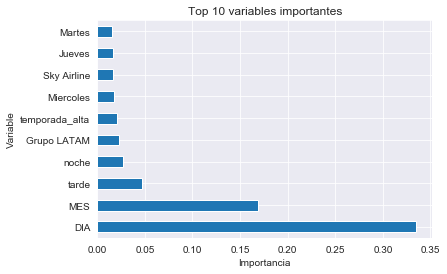

In [188]:
def feature_importance(model):
    ax= plt.subplot()
    feat_importances = pd.Series(model.feature_importances_, index=X.columns)
    feat_importances.nlargest(10).plot(kind='barh')
    ax.set_title('Top 10 variables importantes')
    ax.set_ylabel('Variable')
    ax.set_xlabel('Importancia')

feature_importance(rf_model)

#### 2. Matriz de confusión

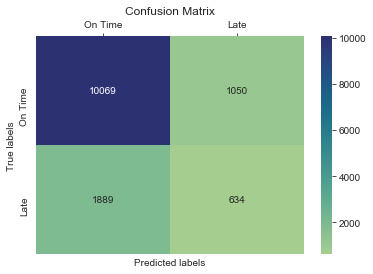

In [192]:
def conf_matrix(real, pred):
    cm = confusion_matrix(real, pred)

    ax= plt.subplot()
    sns.heatmap(cm, annot=True, fmt='g', cmap="crest",ax=ax) #annot=True to annotate cells, ftm='g' to disable scientific notation

    ax.xaxis.tick_top()
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(['On Time', 'Late']); ax.yaxis.set_ticklabels(['On Time', 'Late'])

conf_matrix(y_test, y_pred)

#### 3. Precision, Recall, F1-score, Accuracy

In [171]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.91      0.87     11119
           1       0.38      0.25      0.30      2523

    accuracy                           0.78     13642
   macro avg       0.61      0.58      0.59     13642
weighted avg       0.76      0.78      0.77     13642



Probemos ahora un modelo de XGBoost para ver si podemos obtener un mejor accuracy.

In [173]:
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train, y_train)

/Users/javiera/Library/Python/3.8/lib/python/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/javiera/Library/Python/3.8/lib/python/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [180]:
pred_y = xgb_model.predict(X_test)
xgb_probability = xgb_model.predict_proba(X_test)


Veamos las mismas métricas anteriores pero ahora para el modelo de XGBoost, tales como la matriz de confusión, accuracy,
recall, f1-score, precision y además de la importancia de las variables con las que se entrena el modelo.

#### 1. Importancia de las variables

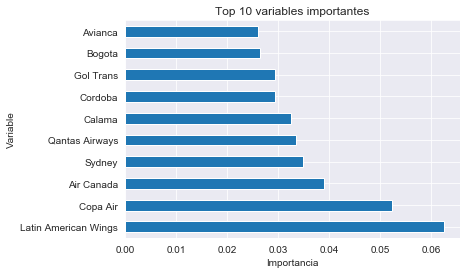

In [190]:
# Usamos la función previamente creada
feature_importance(xgb_model)

#### 2. Matriz de confusión

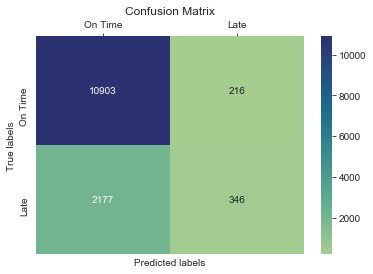

In [193]:
# Usamos la función previamente creada
conf_matrix(y_test, pred_y)

#### 3. Precision, Recall, F1-score, Accuracy

In [182]:
print(classification_report(y_test, pred_y))

              precision    recall  f1-score   support

           0       0.83      0.98      0.90     11119
           1       0.62      0.14      0.22      2523

    accuracy                           0.82     13642
   macro avg       0.72      0.56      0.56     13642
weighted avg       0.79      0.82      0.78     13642



Comparando ambos modelos entrenados, Random Forest y XGBoost, vemos que ambos tienen un buen performance, sobre 50% de
accuracy, 78% y 82% respectivamente. Los modelos les asignan distintas importancias a las variables, donde el
Random Forest considera más importantes las variables día, mes y periodo del día, mientras que el XGBoost da mayor
importancia a variables de las aerolíneas y los destinos.

Se decidió utilizar el accuracy para medir la performance del modelo dado que representa el porcentaje de error del
modelo, es decir, la fracción de predicciones que el modelo realizó correctamente.

Viendo la matriz de confusión, el modelo de XGBoost predice que salen más vuelos a tiempo que realmente salieron
atrasados de lo que predice el Random Forest (2177 XGBoost vs 1889 RF), pero se equivoca menos en la predicción de los
que salen atrasados que realmente salieron a tiempo (216 XGBoost vs 1050 RF), es por eso que los valores de precision y
recall aumentan y disminuyen respectivamente para la categoría atrasado (clase 1) comparando RF vs XGBoost.

Sin embargo estas métricas nos indican que tenemos un dataset desbalanceado, tal como se puede comprobar con la tasa de
atraso previamente calculada de 18%, es decir, 18% de nuestros datos se encuentran etiquetados como atrasados.

Para trabajar sobre un dataset desbalanceado realizaremos un modelo de Ensamble con balanceo.

In [196]:
bbc_model = BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(),
                                sampling_strategy='auto',
                                replacement=False,
                                random_state=0)
bbc_model.fit(X_train, y_train)

/Users/javiera/Library/Python/3.8/lib/python/site-packages/sklearn/ensemble/_bagging.py:719: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(),
                          random_state=0)

In [197]:
pred_y_bbc = bbc_model.predict(X_test)


#### 1. Matriz de confusión

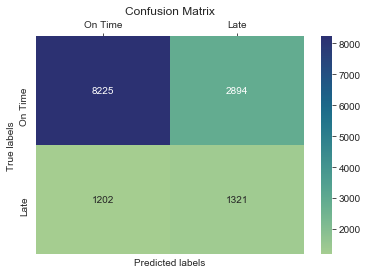

In [199]:
# Usamos la función previamente creada
conf_matrix(y_test, pred_y_bbc)

#### 2. Precision, Recall, F1-score, Accuracy

In [200]:
print(classification_report(y_test, pred_y_bbc))

              precision    recall  f1-score   support

           0       0.87      0.74      0.80     11119
           1       0.31      0.52      0.39      2523

    accuracy                           0.70     13642
   macro avg       0.59      0.63      0.60     13642
weighted avg       0.77      0.70      0.73     13642



Con este modelo tenemos claramente valores más balanceados, dado que al tener un dataset desbalanceado estábamos
obteniendo un alto valor de precisión en la clase mayoritaria y un bajo recall en la clase minoritaria, con este nuevo 
modelo las métricas se encuentran más balanceadas y podemos mirar con mayor confianza el accuracy. Siendo este de un 
70%, es un accuracy más bajo que los obtenido en los modelos anteriores, pero de mayor confiabilidad dado que se trabajó 
para considerar las clases balanceadas. 70% es un buen número para tratarse de datos reales, dado que en la vida real 
no se cuenta nunca con modelos completamente perfectos, pero siempre se busca trabajar en maximizar las métricas.

Para mejorar la performance de los modelos se puede realizar tuneo de hiperparámetros, existen herramientas de python
que permiten encontrar el mejor set de parámetros para entrenar el modelo y maximizar el accuracy.

Se decidió trabajar con Random Forest y XGBoost dado que después de probar con el modelo de probit, que no convergió,
los modelos de árboles son buenos predictores de problemas de analítica. No es necesario entrenar modelos tan complejos,
como por ejemplo redes neuronales para encontrar una solución que se ajuste a un problema, son costo eficientes y tiempo
eficientes, los modelos de árboles son rápidos de entrenar y escalables. Finalmente se decidió probar un modelo de 
ensamble con balanceo para trabajar con las clases que se encontraban desbalanceadas en el dataset original, y con esto 
obtener una mayor confianza en el valor del accuracy obtenido.